In [1]:
# 1-MONTH, 3-MONTH, 6-MONTH, 1-YEAR RETURN PRICE

In [2]:
ALPHAVANTAGE_API_ENDPOINT = "https://www.alphavantage.co/query?"
ALPHAVANTAGE_APIKEY = "KE7MBHHWS14Q5O95"

In [3]:
import nasdaqdatalink
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [4]:
nasdaqdatalink.read_key(filename="data_link_apikey/apikey")

In [5]:
def fetch_data_intraday(stock):
    '''GET request to alphavantage API to download csv and save it in assets'''
    parameters_intraday = {
    'function': 'TIME_SERIES_INTRADAY',
    'symbol': stock,
    'interval': '5min',
    'apikey': ALPHAVANTAGE_APIKEY,
    'datatype': 'csv'
}
    response = requests.get(url=ALPHAVANTAGE_API_ENDPOINT, params=parameters_intraday)
    if response.status_code == 200:
        daily_data = response.text
        with open(rf'{stock}_intraday.csv', mode='w') as file:
            file.write(daily_data)

In [6]:
def fetch_data_daily(stock):
    '''GET request to alphavantage API to download csv and save it in assets'''
    parameters_daily = {
    'function': 'TIME_SERIES_DAILY',
    'symbol': stock,
    'apikey': ALPHAVANTAGE_APIKEY,
    'datatype': 'csv'
}
    response = requests.get(url=ALPHAVANTAGE_API_ENDPOINT, params=parameters_daily)
    if response.status_code == 200:
        daily_data = response.text
        with open(rf'{stock}_daily.csv', mode='w') as file:
            file.write(daily_data)

In [7]:
class Entity:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.create_bands()
        self.create_margins()
        self.detect_points()

    def create_bands(self, WINDOW=20):
        self.df['ma'] = self.df['close'].rolling(window=WINDOW).mean()
        self.df['ub'] = self.df['close'].rolling(window=WINDOW).mean() + (self.df['close'].std()* 2)
        self.df['lb'] = self.df['close'].rolling(window=WINDOW).mean() - (self.df['close'].std()* 2)

    def create_margins(self, ERROR=0.001):
        self.df['l_margin'] = self.df['close'] - self.df['close'] * 0.001
        self.df['u_margin'] = self.df['close'] + self.df['close'] * 0.001

    def plot_bands(self, N_SAMPLES=0):
        plt.plot(self.df['close'][N_SAMPLES:])
        plt.plot(self.df['ma'][N_SAMPLES:])
        plt.plot(self.df['ub'][N_SAMPLES:])
        plt.plot(self.df['lb'][N_SAMPLES:])
        
    def plot_margins(self): 
        plt.plot(self.df['ub'])
        plt.plot(self.df['u_margin'])
        plt.plot(self.df['close'])
        plt.plot(self.df['l_margin'])
        plt.plot(self.df['lb'])

    def detect_points(self, MARGINS=False):
        if MARGINS == False:
            self.BUY_POINTS = np.array(self.df[(self.df['close'] <= self.df['lb'])]['timestamp'])
            self.SELL_POINTS = np.array(self.df[(self.df['close'] >= self.df['ub'])]['timestamp'])
        else:
            self.BUY_POINTS = np.array(self.df[(self.df['l_margin'] <= self.df['lb'])]['timestamp'])
            self.SELL_POINTS = np.array(self.df[(self.df['u_margin'] >= self.df['ub'])]['timestamp'])

    def plot_points(self):
        plt.plot(self.df['close'])
        for n in range(len(self.BUY_POINTS)):
            plt.plot(self.df[self.df['timestamp'] == self.BUY_POINTS[n]]['close'], '^', color='g')
        for n in range(len(self.SELL_POINTS)):
            plt.plot(self.df[self.df['timestamp'] == self.SELL_POINTS[n]]['close'], 'v', color='r')


In [70]:
class EntityV2:
    def __init__(self, df_daily: pd.DataFrame, df_intraday: pd.DataFrame):
        self.df_daily = df_daily
        self.df_intraday = df_intraday
        self.create_bands()
        self.create_margins()
        self.detect_points()
        self.ma_5()
        self.ma_10()
        self.ma_30()
        self.detect_points_daily()

    def create_bands(self, WINDOW=20):
        self.df_intraday['ma'] = self.df_intraday['close'].rolling(window=WINDOW).mean()
        self.df_intraday['ub'] = self.df_intraday['close'].rolling(window=WINDOW).mean() + (self.df_intraday['close'].std()* 2)
        self.df_intraday['lb'] = self.df_intraday['close'].rolling(window=WINDOW).mean() - (self.df_intraday['close'].std()* 2)

    def create_margins(self, ERROR=0.001):
        self.df_intraday['u_margin'] = self.df_intraday['close'] + self.df_intraday['close'] * 0.001
        self.df_intraday['l_margin'] = self.df_intraday['close'] - self.df_intraday['close'] * 0.001

    def ma_5(self):
        self.df_daily['ma5'] = self.df_daily['close'].rolling(window=5).mean() 

    def ma_10(self):
        self.df_daily['ma10'] = self.df_daily['close'].rolling(window=10).mean() 

    def ma_30(self):
        self.df_daily['ma30'] = self.df_daily['close'].rolling(window=30).mean() 

    def plot_bands(self):
        plt.plot(self.df_intraday['close'])
        plt.plot(self.df_intraday['ma'])
        plt.plot(self.df_intraday['ub'])
        plt.plot(self.df_intraday['lb'])
        
    def plot_margins(self): 
        plt.plot(self.df_intraday['ub'])
        plt.plot(self.df_intraday['u_margin'])
        plt.plot(self.df_intraday['close'])
        plt.plot(self.df_intraday['l_margin'])
        plt.plot(self.df_intraday['lb'])

    def plot_ma(self):
        plt.plot(self.df_daily['close'])
        plt.plot(self.df_daily['ma3'])
        plt.plot(self.df_daily['ma5'])
        plt.plot(self.df_daily['ma10'])

    def detect_points(self, MARGINS=False):
        if MARGINS == False:
            self.BUY_POINTS_INTRADAY = np.array(self.df_intraday[(self.df_intraday['close'] <= self.df_intraday['lb'])]['timestamp'])
            self.SELL_POINTS_INTRADAY = np.array(self.df_intraday[(self.df_intraday['close'] >= self.df_intraday['ub'])]['timestamp'])
        else:
            self.BUY_POINTS_INTRADAY = np.array(self.df_intraday[(self.df_intraday['l_margin'] <= self.df_intraday['lb'])]['timestamp'])
            self.SELL_POINTS_INTRADAY = np.array(self.df_intraday[(self.df_intraday['u_margin'] >= self.df_intraday['ub'])]['timestamp'])

    def plot_points(self):
        plt.plot(self.df_intraday['close'])
        for n in range(len(self.BUY_POINTS_INTRADAY)):
            plt.plot(self.df_intraday[self.df_intraday['timestamp'] == self.BUY_POINTS_INTRADAY[n]]['close'], '^', color='g')
        for n in range(len(self.SELL_POINTS_INTRADAY)):
            plt.plot(self.df_intraday[self.df_intraday['timestamp'] == self.SELL_POINTS_INTRADAY[n]]['close'], 'v', color='r')

    def detect_points_daily(self, ma='ma3'):
        self.BUY_POINTS_DAILY = []
        self.SELL_POINTS_DAILY = []
        self.BUY_POINTS_DAILY = np.array(self.df_daily[(self.df_daily['close'] <= self.df_daily[ma])]['timestamp'])
        self.SELL_POINTS_DAILY = np.array(self.df_daily[(self.df_daily['close'] >= self.df_daily[ma])]['timestamp'])

    def plot_points_daily(self):
        plt.plot(self.df_daily['close'])
        for n in range(len(self.BUY_POINTS_DAILY)):
            plt.plot(self.df_daily[self.df_daily['timestamp'] == self.BUY_POINTS_DAILY[n]]['close'], '^', color='g')
        for n in range(len(self.SELL_POINTS_DAILY)):
            plt.plot(self.df_daily[self.df_daily['timestamp'] == self.SELL_POINTS_DAILY[n]]['close'], 'v', color='r')



In [9]:
def create_bands(df, WINDOW=20):
    df['ma'] = df['close'].rolling(window=WINDOW).mean()
    df['ub'] = df['close'].rolling(window=WINDOW).mean() + (df['close'].std()* 2)
    df['lb'] = df['close'].rolling(window=WINDOW).mean() - (df['close'].std()* 2)

In [10]:
def create_margins(df, ERROR=0.001):
    df['l_margin'] = df['close'] - df['close'] * 0.001
    df['u_margin'] = df['close'] + df['close'] * 0.001

In [11]:
def plot_bands(df, N_SAMPLES=0):
    plt.plot(df['close'][N_SAMPLES:])
    plt.plot(df['ma'][N_SAMPLES:])
    plt.plot(df['ub'][N_SAMPLES:])
    plt.plot(df['lb'][N_SAMPLES:])

In [12]:
def plot_margins(df): 
    plt.plot(df['ub'])
    plt.plot(df['u_margin'])
    plt.plot(df['close'])
    plt.plot(df['l_margin'])
    plt.plot(df['lb'])

In [13]:
def detect_points(df, MARGINS=False):
    if MARGINS == False:
        BUY_POINTS = df[(df['close'] <= df['lb'])]['timestamp']
        SELL_POINTS = df[(df['close'] >= df['ub'])]['timestamp']
    else:
        BUY_POINTS = df[(df['l_margin'] <= df['lb'])]['timestamp']
        SELL_POINTS = df[(df['u_margin'] >= df['ub'])]['timestamp']
    return np.array(SHORT_POINTS), np.array(SELL_POINTS)

In [14]:
def plot_markers(df, short, sell):
    plt.plot(df['close'])
    for n in range(len(short)):
        plt.plot(df[df['timestamp'] == short[n]]['close'], '^', color='g')
    for n in range(len(sell)):
        plt.plot(df[df['timestamp'] == sell[n]]['close'], 'v', color='r')

In [15]:
def load_file(path):
    with open(path) as file:
        return pd.read_csv(file)

In [16]:
def find_correlation(*args):
    df = pd.concat([df['close'] for df in args], axis=1)
    return df.corr()

In [17]:
# fetch_data_intraday('AAPL')
# fetch_data_intraday('MSFT')
# fetch_data_intraday('GOOGL')
# fetch_data_intraday('META')

# fetch_data_daily('AAPL')
# fetch_data_daily('MSFT')
# fetch_data_daily('GOOGL')
# fetch_data_daily('META')

In [18]:
df_aapl_intraday = load_file('AAPL_intraday.csv')
df_msft_intraday = load_file('MSFT_intraday.csv')
df_googl_intraday = load_file('GOOGL_intraday.csv')
df_meta_intraday = load_file('META_intraday.csv')

df_aapl_daily = load_file('AAPL_daily.csv')
df_msft_daily = load_file('MSFT_daily.csv')
df_googl_daily = load_file('GOOGL_daily.csv')
df_meta_daily = load_file('META_daily.csv')

In [19]:
find_correlation(df_aapl_daily, df_msft_daily, df_googl_daily, df_meta_daily)

,close,close,close,close
close,1.000000,0.791406,-0.254678,0.426206
close,0.791406,1.000000,-0.176138,0.368201
close,-0.254678,-0.176138,1.000000,0.539701
close,0.426206,0.368201,0.539701,1.000000


In [20]:
# aapl_intraday = Entity(df_aapl_intraday)
# msft_intraday = Entity(df_msft_intraday)
# googl_intraday = Entity(df_googl_intraday)
# meta_intraday = Entity(df_meta_intraday)

In [21]:
# aapl_daily = Entity(df_aapl_daily)
# msft_daily = Entity(df_msft_daily)
# googl_daily = Entity(df_googl_daily)
# meta_daily = Entity(df_meta_daily)

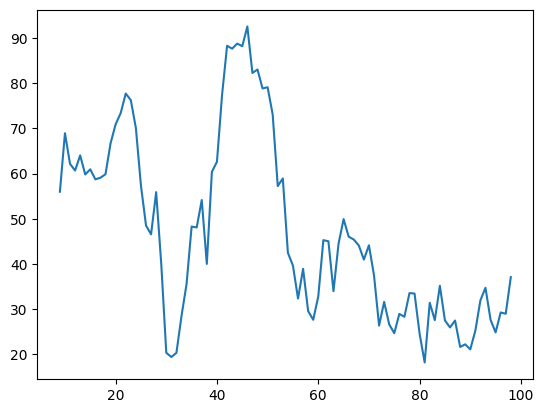

In [22]:
gain = []
loss = []
for n in range(len(df_aapl_daily['close'])-1):
    delta = df_aapl_daily['close'][n+1] - df_aapl_daily['close'][n]
    if delta > 0:
        gain.append(delta)
        loss.append(0)
    else:
        gain.append(0)
        loss.append((delta)*(-1))
avg_gain = pd.Series(gain).rolling(10).mean()
avg_loss = pd.Series(loss).rolling(10).mean()
rs = avg_gain/avg_loss
rsi = (100-(100)/(1+rs))
plt.plot(rsi)

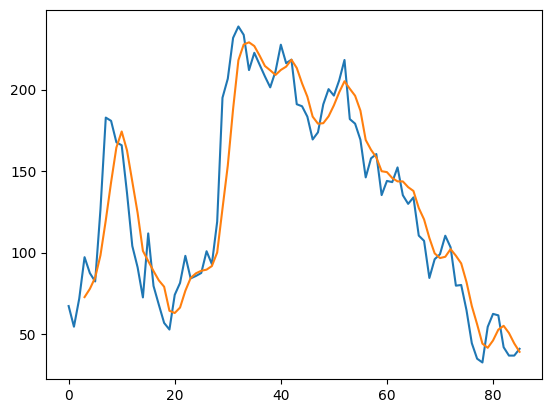

In [23]:
K = []
for n in range(14, len(df_aapl_daily['close'])):
    k = (df_aapl_daily['close'][n] - df_aapl_daily['low'][:14].min()) / (df_aapl_daily['high'][:14].max() - df_aapl_daily['low'][:14].min()) * 100
    K.append(k)
K = pd.Series(K)
D = K.rolling(4).mean()
plt.plot(K)
plt.plot(D)

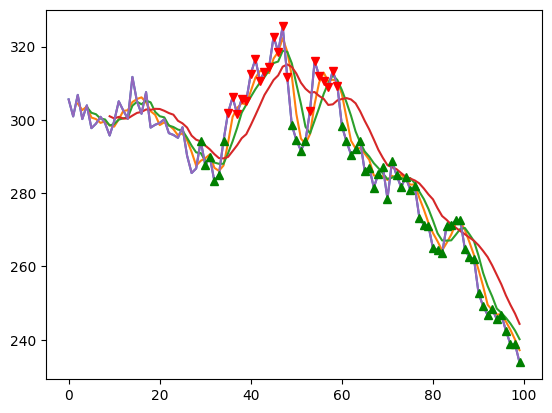

In [73]:
meta = EntityV2(df_intraday=df_meta_intraday, df_daily=df_meta_daily)
meta.plot_ma()
meta.detect_points_daily(ma='ma30')
meta.plot_points_daily()